# # Bootstrap analysis for testing with num_repeats


```
./bootstrap_test.sh "-m whisper_base -l 2 -d ucdavis -b 50 -i itr"
```

# Bootstrap analysis for testing with num_repeats
This notebook is to guide through the process of doing bootstrap analysis for the number of trial repeats used at test time to compute the correlations.

Here is step by step process;

**1. Using different number of trial repeats test the model** \
This repository provides functionality to fit TRF (temporal receptive field) model from features representations -- DNN features of STRF -- to neural data. I have also provided script using the pipeline for the bootstrap analysis.  
`/scripts/bootstrap_fit.py`: provides functionaltiy to do the bootstrap analysis for both training data and number of trials for testing. This provides quite generic implementation and flags are specified at job submission time to get the desired functionality.  
`/Gilbreth_job_submission/bootstrap_fit.sh`: This job submission scripts request resources (GPU, memory etc.) from slurm and the runs the script mentioned above.  
`/Gilbreth_job_submission/bootstrap_test.sh`: This .sh script takes in the command line arguments and adds specific options like number of trials in a loop and submits the above scripts. This basically uses *bootstrap_fit.sh* and it meant to make job submissions easier. Here is an example command to submit scripts for test bootstrap for one iteration. 
```
./bootstrap_test.sh "-m whisper_base -l 2 -d ucdavis -b 50 -i itr"
```
This will submit 3 jobs and results will be saved with identifiers; 
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot_test_\_[itr]\_1$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot_test_\_[itr]\_2$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot_test_\_[itr]\_3$

Modify the *bootstrap_test.sh* script in case this needs to be done for number of repeats greater than 3.

In order to do, say, 80 samples of bootstrap, run this command with itr from 1 to 80. This will 

**2. Make sure the normalizer are computed and saved** \
Make sure the normalizers are computed and saved to the memory for all the sessions (or at least the ones that are included in the bootstrap analysis). Sessions to be included in the bootsrap analysis can be specified within the script `bootstrap_fit.py`. In case there are large number of sessions being analysed, running this code as a batch script would be a better option. Nevertheless the code is a couple of lines of code as given below.

In [1]:
from auditory_cortex.neural_data.normalizer_calculator import NormalizerCalculator
bin_width = 50
mVocs = True
session_ids = [0,1,2]
for sess_id in session_ids:
    normalizer = NormalizerCalculator('ucdavis', sess_id)

    dist = normalizer.get_normalizer_for_session_random_pairs(
        bin_width=bin_width, mVocs=mVocs
    )

**3. Make sure the null distributions are computed** \
Make sure the null distribution is computed and saved to the memory. Normally null distribution using random poisson sequences is used so one null distributions is computed for the entire stimulus set. It actually depends on the length of the long sequences (i.e. duration of repeated stimuli).

In [ ]:
from auditory_cortex.neural_data.normalizer_calculator import NormalizerCalculator
# any session id will work, as the stimuli are the same for all sessions in a dataset
sess_id = 0	
bin_width = 50
mVocs = True
num_itr=100000
normalizer = NormalizerCalculator('ucdavis', sess_id)
null_dist_ucdavis = normalizer.get_normalizer_null_dist_using_poisson(
    bin_width=bin_width, num_itr=num_itr, mVocs=mVocs)

**4. Combining results, adding normalizers to all the results saved in the first step** \
After we have saved all the results of the first step, and computed normalizer as well as null distribution, we can start analyzing the results of bootsrap analysis. The first step is to combine the results for number of trials used for testing, for each iteration, so that we have only one file for one iteration. **In every saved results, N_sents corresponds to the number of trials used for testing. N_sents means other things for e.g. bootstrap_training analysis.** Next we incorporate the normalizer into the saved results. For 80 iterations of bootsrap, we will have 80*3=240 files saved to the memory. After combining they would reduce to 80 and we'll then update the normalizer for each of these files in a loop. So I have written the helper functions to help with that. For now, I am defining them within this notebook, I might move them to a separate helper class.

In [1]:
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()

import numpy as np
from auditory_cortex.io_utils import ResultsManager
from auditory_cortex.analyses.correlations_analyzer import Correlations

def check_bootstrap_results(
    model_names, identifier, num_sessions, bin_width=50,
    verbose=False, n_test_trials_list=None, percent_durations=None
    ):
    """Check if the bootstrap results are done for all sessions
    """
    models_not_done = []
    if n_test_trials_list is None:
        n_test_trials_list = [1, 2, 3]
    if percent_durations is None:
        percent_durations = [20, 40, 60, 80, 100]
    for model_name in model_names:
        for n_test_trials in n_test_trials_list:
            for dur in percent_durations:
                not_done = ResultsManager.check_results(
                    model_name, f'{identifier}_tr_{n_test_trials}_dur_{dur}',
                    verbose=verbose, num_sessions=num_sessions
                )
                models_not_done.extend(not_done)

    # remove None entries..
    while None in models_not_done:
        models_not_done.remove(None)
    
    if len(models_not_done) ==0:
        logging.info(f"All models done..for {identifier}")
    else:
        logging.info(f"Models with incomplete resutls:")
        for iden in models_not_done:
            logging.info(iden)

def combine_bootstrap_results(
    model_names, identifier, n_test_trials_list=None, percent_durations=None
    ):
    """Combines results for the list of models provided"""

    if n_test_trials_list is None:
        n_test_trials_list = [1, 2, 3]
    if percent_durations is None:
        percent_durations = [20, 40, 60, 80, 100]
    for model_name in model_names:
        # ids = [f'{identifier}_{N}' for N in N_sents]
        ids = [
            f'{identifier}_tr_{n_test_trials}_dur_{dur}'
            for n_test_trials in n_test_trials_list
            for dur in percent_durations
        ]
        ResultsManager.merge_correlation_results(
            model_name,
            ids, 
            output_identifier=identifier
        )

In [ ]:
model_names = [
    'whisper_base',
]
dataset_name = 'ucdavis'
mVocs = False
bin_width = 50
num_sessions = 9
identifier = 'exp_design'
stim = 'mVocs' if mVocs else 'timit'
results_identifier = ResultsManager.get_run_id(
            dataset_name, bin_width, identifier, mVocs=mVocs, shuffled=False, lag=200,
            bootstrap=True, test_bootstrap=True
        )
identifiers = [f"{results_identifier}_{i}" for i in range(1, 51)]
n_test_trials_list = np.arange(1, 13)
percent_durations = [20, 40, 60, 80, 100]

In [ ]:
verbose = False
for identifier in identifiers:
    check_bootstrap_results(
        model_names, identifier, num_sessions, bin_width=bin_width, verbose=verbose,
        n_test_trials_list=n_test_trials_list, percent_durations=percent_durations
        )

Combining all files of one iteration into 1. Within that file, **n_test_trials** specifies number of trial repeats used for testing and **percent_duration** specifies the duration of test data used to evaluate.

In [ ]:
for identifier in identifiers:
    combine_bootstrap_results(
        model_names, identifier, n_test_trials_list, percent_durations
        )

Adding the normalizer to each file.

In [ ]:
dataset_name = 'ucdavis'
mVocs = False
bin_width = 50
num_sessions = 9
identifier = 'exp_design'
stim = 'mVocs' if mVocs else 'timit'
results_identifier = ResultsManager.get_run_id(
            dataset_name, bin_width, identifier, mVocs=mVocs, shuffled=False, lag=200,
            bootstrap=True, test_bootstrap=True
        )
identifiers = [f"{results_identifier}_{i}" for i in range(1, 51)]

In [ ]:
model_name = 'whisper_base'
for identifier in identifiers:
    corr_obj = Correlations(model_name+'_'+identifier)
    corr_obj.set_normalizers_using_bootsrap(mVocs=mVocs)
    print(f"Done for identifier: {identifier}")

**5. Computing medians of distributions and saving to disk**

In [19]:
from auditory_cortex.analyses.correlations_analyzer import Correlations
from auditory_cortex.io_utils import io
def get_medians_for_single_itr(corr_obj, bin_width=50, mVocs=False):
    """Get median of corr distribution for each N_sents, for a single iteration
    """
    threshold = corr_obj.get_normalizer_threshold(bin_width=bin_width, mVocs=mVocs)
    select_data = corr_obj.get_selected_data(threshold=threshold, bin_width=bin_width, mVocs=mVocs)
    if mVocs:
        column = 'mVocs_normalized_test_cc'
    else:
        column = 'normalized_test_cc'
    medians = {}
    N_sents = select_data['N_sents'].unique()
    for N in N_sents:
        medians[N] = select_data[select_data['N_sents'] == N][column].median()
    return medians

def get_median_dist_for_all_itr(identifiers, model_name, bin_width=50, mVocs=False):

    median_dists = {}
    for identifier in identifiers:
        corr_obj = Correlations(model_name+'_'+identifier)
        medians = get_medians_for_single_itr(corr_obj, bin_width=bin_width, mVocs=mVocs)
        for N, median in medians.items():
            if N not in median_dists:
                median_dists[N] = []
            median_dists[N].append(median)

    return median_dists

def get_bootstrap_medians(
    identifiers, model_name, dataset_name='ucsf', force_redo=False, test=False, mVocs=False
    ):
    if not force_redo:
        median_dist = io.read_bootstrap_median_dist(
            model_name, bin_width=50, mVocs=mVocs, verbose=True, test=test,
            dataset_name=dataset_name
            )
        if median_dist is not None:
            return median_dist
    median_dist = get_median_dist_for_all_itr(identifiers, model_name=model_name, bin_width=50, mVocs=mVocs)
    io.write_bootstrap_median_dist(
        median_dist, model_name, bin_width=50, mVocs=mVocs, test=test,
        dataset_name=dataset_name
        )
    return median_dist

In [20]:
model_name = 'whisper_base'
dataset_name='ucdavis'
mVocs = False
test=True
dist = get_bootstrap_medians(identifiers, model_name, dataset_name=dataset_name, test=test, mVocs=mVocs,
    force_redo=True)

Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normalizer'...
Applying threshold: 0.032 on column: 'normaliz

**6. Plotting...**
- timit

Text(0.5, 1.0, "Bootstrap: test trials for 'ucdavis' and 'timit'")

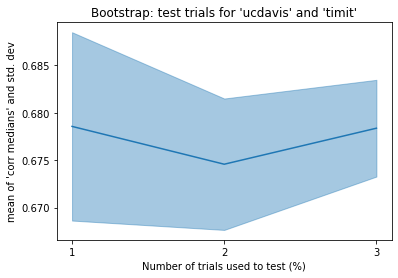

In [21]:
import numpy as np
import matplotlib.pyplot as plt

model_name = 'whisper_base'
dataset_name = 'ucdavis'
mVocs=False
test=True
bin_width = 50
if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'

identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_test_{i}' for i in range(1, 81)]
median_dists = get_bootstrap_medians(
    identifiers, model_name, dataset_name=dataset_name, test=test, mVocs=mVocs)
proportion_of_data = list(median_dists.keys())
means = [np.mean(median_dists[N]) for N in proportion_of_data]
std_errors = [np.std(median_dists[N]) for N in proportion_of_data]

std_errors = np.array(std_errors)
plt.plot(proportion_of_data, means, label='Mean', color='tab:blue')

# Plot the standard error as shaded region
plt.fill_between(proportion_of_data, means - std_errors/2, means + std_errors/2, 
                 color='tab:blue', alpha=0.4, label='Standard Error')
plt.xticks(proportion_of_data)
plt.xlabel('Number of trials used to test (%)')
plt.ylabel("mean of 'corr medians' and std. dev")
plt.title(f"Bootstrap: test trials for '{dataset_name}' and '{stim}'")

- mVocs

Text(0.5, 1.0, "Bootstrap: test trials for 'ucdavis' and 'mVocs'")

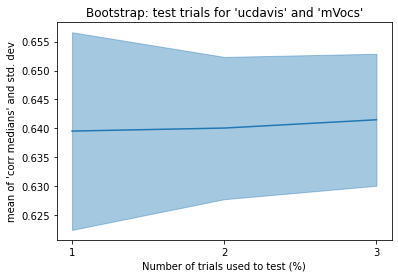

In [14]:
import numpy as np
import matplotlib.pyplot as plt

model_name = 'whisper_base'
dataset_name = 'ucdavis'
mVocs=True
test=True
bin_width = 50
if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'

identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_test_{i}' for i in range(1, 81)]
median_dists = get_bootstrap_medians(
    identifiers, model_name, dataset_name=dataset_name, test=test, mVocs=mVocs)
proportion_of_data = list(median_dists.keys())
means = [np.mean(median_dists[N]) for N in proportion_of_data]
std_errors = [np.std(median_dists[N]) for N in proportion_of_data]

std_errors = np.array(std_errors)
plt.plot(proportion_of_data, means, label='Mean', color='tab:blue')

# Plot the standard error as shaded region
plt.fill_between(proportion_of_data, means - std_errors/2, means + std_errors/2, 
                 color='tab:blue', alpha=0.4, label='Standard Error')
plt.xticks(proportion_of_data)
plt.xlabel('Number of trials used to test (%)')
plt.ylabel("mean of 'corr medians' and std. dev")
plt.title(f"Bootstrap: test trials for '{dataset_name}' and '{stim}'")